## Summary

We will use [Ames Housing](http://jse.amstat.org/v19n3/decock.pdf) dataset which was first compiled by Dean De Cock and became better known after it was used in Kaggle challenge. It is a set of 1460 residential homes in Ames, Iowa, each described by 80 features. We will use it to predict the final logarithmic price of the houses. In this example we will use only 20 most interesting features.

## Import libraries

In [1]:
!which python

/Users/mouslydiaw/opt/anaconda3/envs/python39/bin/python


In [2]:
!pip install missingno

In [17]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import scipy as sp
import seaborn as sns
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.datasets import fetch_california_housing, fetch_openml, load_boston, load_diabetes
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             max_error,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder

set_config(display="diagram", print_changed_only=False)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Data collection

In [4]:
def load_dataset(dataset_name):
    selected_features = []
    valid_dataset_name = ("diabete", "house_prices")
    if dataset_name not in valid_dataset_name:
        raise ValueError(f"Expected dataset name should be in {valid_dataset_name}, but you gave {dataset_name}")
    if dataset_name == "diabete":
        dframe = load_diabetes(return_X_y=False, as_frame=True, scaled=False)
    if dataset_name == "house_prices":
        dframe = fetch_openml(name=dataset_name, as_frame=True)
        # select most interesting features
        selected_features = [
            "YrSold",
            "HeatingQC",
            "Street",
            "YearRemodAdd",
            "Heating",
            "MasVnrType",
            "BsmtUnfSF",
            "Foundation",
            "MasVnrArea",
            "LotArea",
            "MSSubClass",
            "ExterQual",
            "Condition2",
            "GarageCars",
            "GarageType",
            "OverallQual",
            "TotalBsmtSF",
            "BsmtFinSF1",
            "HouseStyle",
            "MiscFeature",
            "MoSold",
        ]
    input_x = dframe.data
    target_y = dframe.target
    
    print(f"Shape of raw input features: {input_x.shape}")
    print(f"Shape of target feature : {target_y.shape}")
    print("\nSample - first rows")
    display(input_x.head())
    if selected_features:
        input_x = input_x.loc[:, selected_features]
    print(f"\nFull description of the dataset\n\n{dframe.DESCR}")

    return input_x, target_y

In [5]:
# load data
X, y = load_dataset(dataset_name="house_prices") 
# you can change the the dataset's name if you want to try with boston house pricing or load your own dataset

Shape of raw input features: (1460, 80)
Shape of target feature : (1460,)

Sample - first rows


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal



Full description of the dataset

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY 

In [6]:
X.head()

,YrSold,HeatingQC,Street,YearRemodAdd,Heating,MasVnrType,BsmtUnfSF,Foundation,MasVnrArea,LotArea,MSSubClass,ExterQual,Condition2,GarageCars,GarageType,OverallQual,TotalBsmtSF,BsmtFinSF1,HouseStyle,MiscFeature,MoSold
0,2008.0,Ex,Pave,2003.0,GasA,BrkFace,150.0,PConc,196.0,8450.0,60.0,Gd,Norm,2.0,Attchd,7.0,856.0,706.0,2Story,None,2.0
1,2007.0,Ex,Pave,1976.0,GasA,None,284.0,CBlock,0.0,9600.0,20.0,TA,Norm,2.0,Attchd,6.0,1262.0,978.0,1Story,None,5.0
2,2008.0,Ex,Pave,2002.0,GasA,BrkFace,434.0,PConc,162.0,11250.0,60.0,Gd,Norm,2.0,Attchd,7.0,920.0,486.0,2Story,None,9.0
3,2006.0,Gd,Pave,1970.0,GasA,None,540.0,BrkTil,0.0,9550.0,70.0,TA,Norm,3.0,Detchd,7.0,756.0,216.0,2Story,None,2.0
4,2008.0,Ex,Pave,2000.0,GasA,BrkFace,490.0,PConc,350.0,14260.0,60.0,Gd,Norm,3.0,Attchd,8.0,1145.0,655.0,2Story,None,12.0


In [7]:
X.describe(include="all")

,YrSold,HeatingQC,Street,YearRemodAdd,Heating,MasVnrType,BsmtUnfSF,Foundation,MasVnrArea,LotArea,MSSubClass,ExterQual,Condition2,GarageCars,GarageType,OverallQual,TotalBsmtSF,BsmtFinSF1,HouseStyle,MiscFeature,MoSold
count,1460.000000,1460,1460,1460.000000,1460,1452,1460.000000,1460,1452.000000,1460.000000,1460.000000,1460,1460,1460.000000,1379,1460.000000,1460.000000,1460.000000,1460,54,1460.000000
unique,NaN,5,2,NaN,6,4,NaN,6,NaN,NaN,NaN,4,8,NaN,6,NaN,NaN,NaN,8,4,NaN
top,NaN,Ex,Pave,NaN,GasA,None,NaN,PConc,NaN,NaN,NaN,TA,Norm,NaN,Attchd,NaN,NaN,NaN,1Story,Shed,NaN
freq,NaN,741,1454,NaN,1428,864,NaN,647,NaN,NaN,NaN,906,1445,NaN,870,NaN,NaN,NaN,726,49,NaN
mean,2007.815753,NaN,NaN,1984.865753,NaN,NaN,567.240411,NaN,103.685262,10516.828082,56.897260,NaN,NaN,1.767123,NaN,6.099315,1057.429452,443.639726,NaN,NaN,6.321918
std,1.328095,NaN,NaN,20.645407,NaN,NaN,441.866955,NaN,181.066207,9981.264932,42.300571,NaN,NaN,0.747315,NaN,1.382997,438.705324,456.098091,NaN,NaN,2.703626
min,2006.000000,NaN,NaN,1950.000000,NaN,NaN,0.000000,NaN,0.000000,1300.000000,20.000000,NaN,NaN,0.000000,NaN,1.000000,0.000000,0.000000,NaN,NaN,1.000000
25%,2007.000000,NaN,NaN,1967.000000,NaN,NaN,223.000000,NaN,0.000000,7553.500000,20.000000,NaN,NaN,1.000000,NaN,5.000000,795.750000,0.000000,NaN,NaN,5.000000
50%,2008.000000,NaN,NaN,1994.000000,NaN,NaN,477.500000,NaN,0.000000,9478.500000,50.000000,NaN,NaN,2.000000,NaN,6.000000,991.500000,383.500000,NaN,NaN,6.000000
75%,2009.000000,NaN,NaN,2004.000000,NaN,NaN,808.000000,NaN,166.000000,11601.500000,70.000000,NaN,NaN,2.000000,NaN,7.000000,1298.250000,712.250000,NaN,NaN,8.000000


## EDA: Exploratory Data Analysis

### Data summary

In [8]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

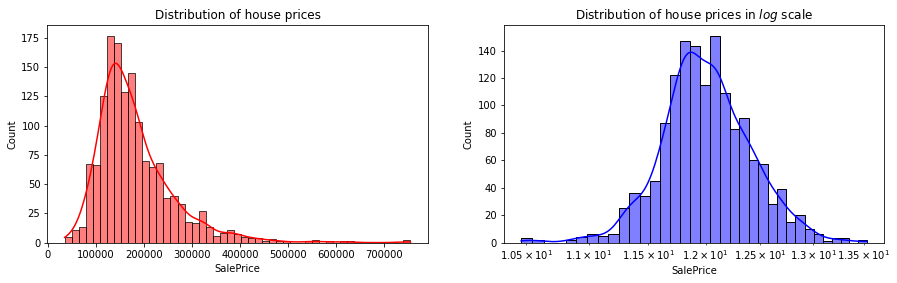

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.histplot(y, color='r', kde=True, ax=axes[0])
axes[0].set_title('Distribution of house prices')

log_y = np.log(y)
sns.histplot(log_y, color='b', kde=True, ax=axes[1])
axes[1].set_title('Distribution of house prices in $log$ scale')
axes[1].set_xscale('log');

If we look at the left plot the sale house price varies from 34900 to 755000, the plot is right skewed. In right plot we will apply natural log, then plot approximately tends to normal. for further analysis we will apply log on target variable charges.Normality is an important assumption for many statistical techniques

- `log`is a particular transformation of Box-Cox
- [Box-Cox transformation](https://www.statisticshowto.com/box-cox-transformation/): A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape.

```from scipy.stats import boxcox
y_bc,lam, ci= boxcox(y,alpha=0.05)```

In [10]:
categorical_features = X.select_dtypes(include="object").columns
print(f"Categorical features:\n {categorical_features}\n")

numerical_features = X.select_dtypes(include="number").columns
print(f"Numerical features:\n {numerical_features}")

Categorical features:
 Index(['HeatingQC', 'Street', 'Heating', 'MasVnrType', 'Foundation',
       'ExterQual', 'Condition2', 'GarageType', 'HouseStyle', 'MiscFeature'],
      dtype='object')

Numerical features:
 Index(['YrSold', 'YearRemodAdd', 'BsmtUnfSF', 'MasVnrArea', 'LotArea',
       'MSSubClass', 'GarageCars', 'OverallQual', 'TotalBsmtSF', 'BsmtFinSF1',
       'MoSold'],
      dtype='object')


In [11]:
feature_names = X.columns

In [12]:
len(feature_names)

21

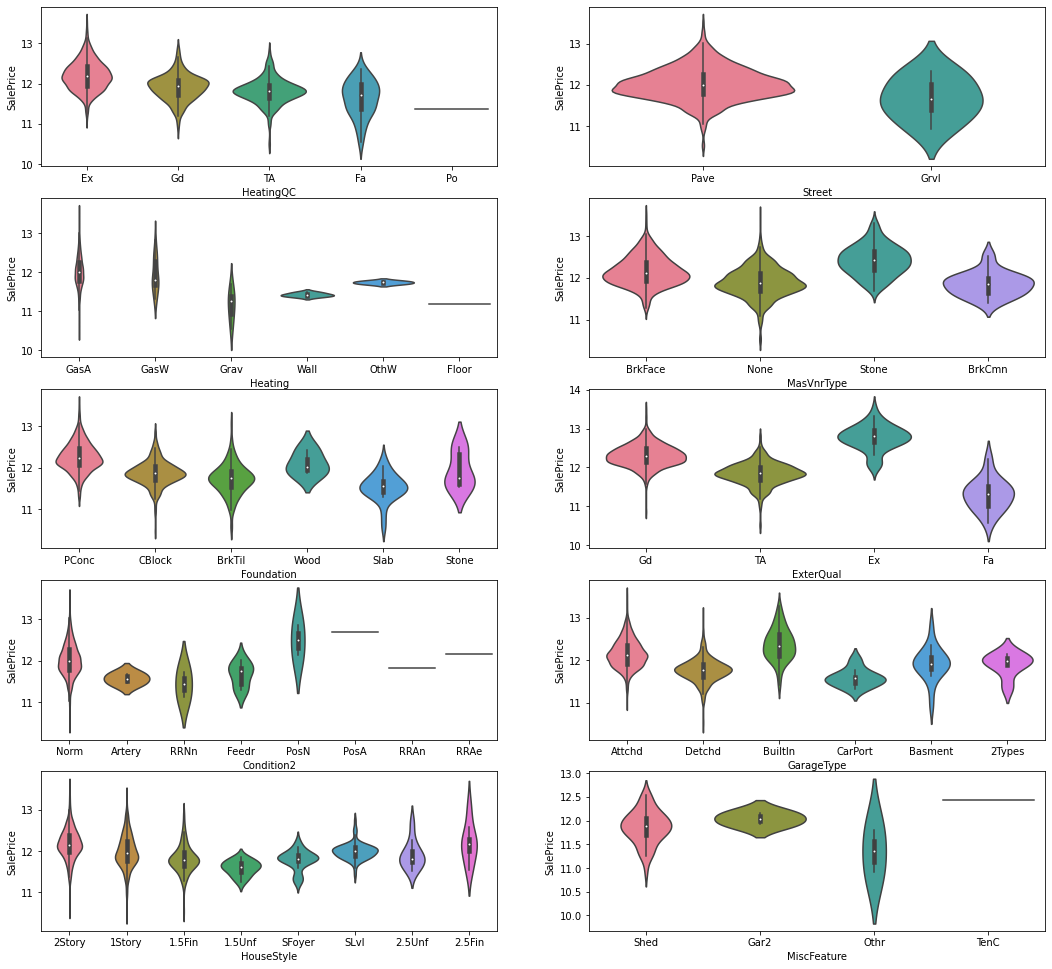

In [13]:
ncols = 2  # number of columns in subplot
nrows = sum(divmod(len(categorical_features), ncols))  # number of rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 17))
axes = axes.ravel()

for i, col_name in enumerate(categorical_features):
    ax = axes[i]
    sns.violinplot(x=col_name, y=log_y, data=X, palette='husl', ax=ax)


In [14]:
pd.crosstab(index=X.HouseStyle, columns=X.Heating, margins=True, margins_name="Total", dropna=False)

Heating,Floor,GasA,GasW,Grav,OthW,Wall,Total
HouseStyle,,,,,,,
1.5Fin,0,143,7,3,0,1,154
1.5Unf,0,12,0,2,0,0,14
1Story,1,715,5,2,0,3,726
2.5Fin,0,8,0,0,0,0,8
2.5Unf,0,8,2,0,1,0,11
2Story,0,440,4,0,1,0,445
SFoyer,0,37,0,0,0,0,37
SLvl,0,65,0,0,0,0,65
Total,1,1428,18,7,2,4,1460


In [15]:
X.head()

,YrSold,HeatingQC,Street,YearRemodAdd,Heating,MasVnrType,BsmtUnfSF,Foundation,MasVnrArea,LotArea,MSSubClass,ExterQual,Condition2,GarageCars,GarageType,OverallQual,TotalBsmtSF,BsmtFinSF1,HouseStyle,MiscFeature,MoSold
0,2008.0,Ex,Pave,2003.0,GasA,BrkFace,150.0,PConc,196.0,8450.0,60.0,Gd,Norm,2.0,Attchd,7.0,856.0,706.0,2Story,None,2.0
1,2007.0,Ex,Pave,1976.0,GasA,None,284.0,CBlock,0.0,9600.0,20.0,TA,Norm,2.0,Attchd,6.0,1262.0,978.0,1Story,None,5.0
2,2008.0,Ex,Pave,2002.0,GasA,BrkFace,434.0,PConc,162.0,11250.0,60.0,Gd,Norm,2.0,Attchd,7.0,920.0,486.0,2Story,None,9.0
3,2006.0,Gd,Pave,1970.0,GasA,None,540.0,BrkTil,0.0,9550.0,70.0,TA,Norm,3.0,Detchd,7.0,756.0,216.0,2Story,None,2.0
4,2008.0,Ex,Pave,2000.0,GasA,BrkFace,490.0,PConc,350.0,14260.0,60.0,Gd,Norm,3.0,Attchd,8.0,1145.0,655.0,2Story,None,12.0


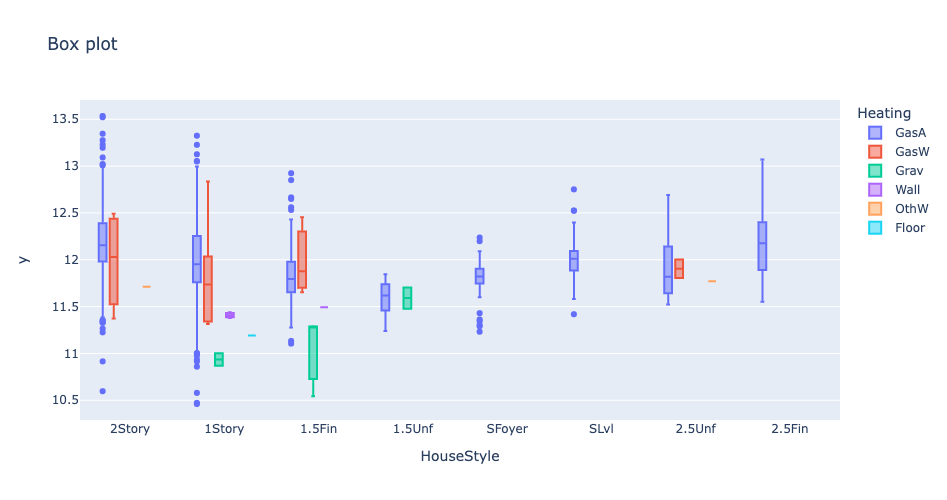

In [37]:
px.box(data_frame=X, y=log_y,
       x="HouseStyle", color="Heating",
       title="Box plot",
       #hover_data=["Heating"],
       boxmode="group",
       #notched=True, # used notched shape
       points=None,
       width=900,
       height=500,
      )

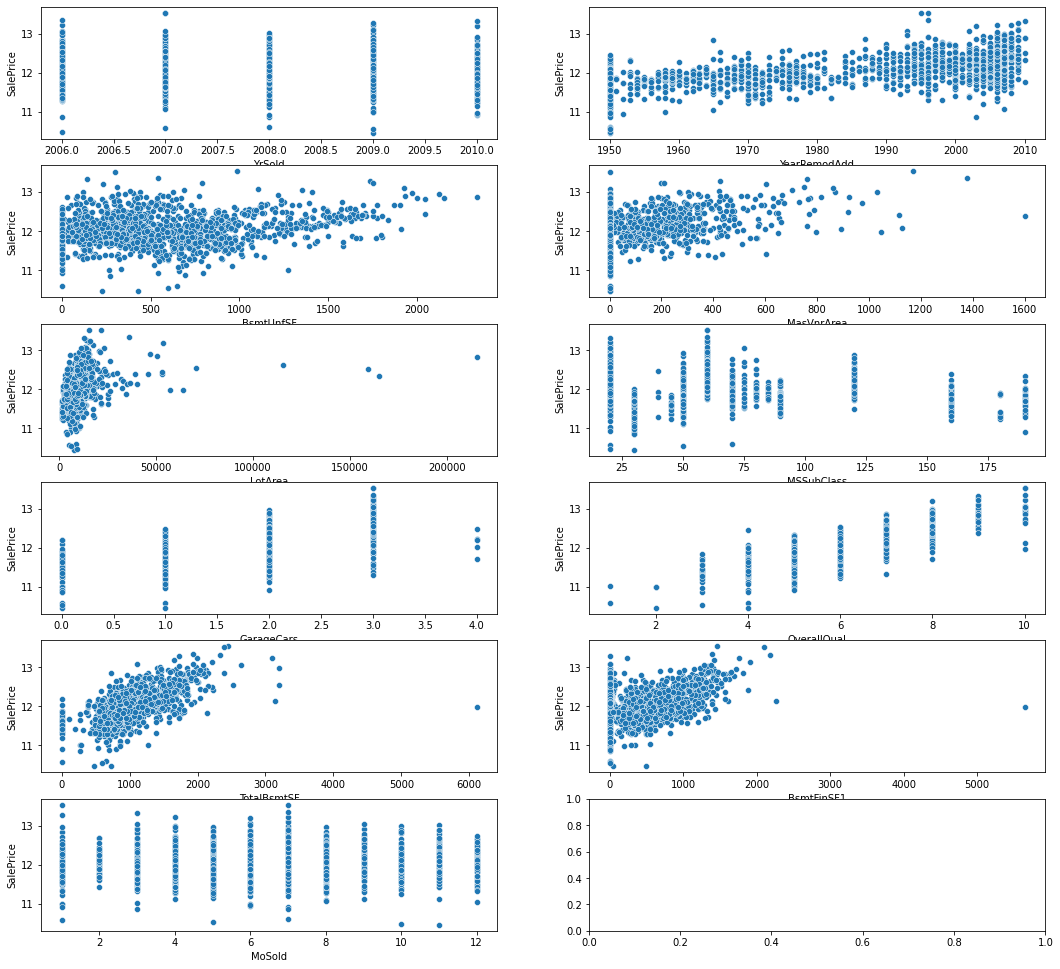

In [38]:
nrows = sum(divmod(len(numerical_features), ncols))  # number of rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 17))
axes = axes.ravel()

for i, col_name in enumerate(numerical_features):
    sns.scatterplot(x=col_name, y=log_y, data=X, ax=axes[i])

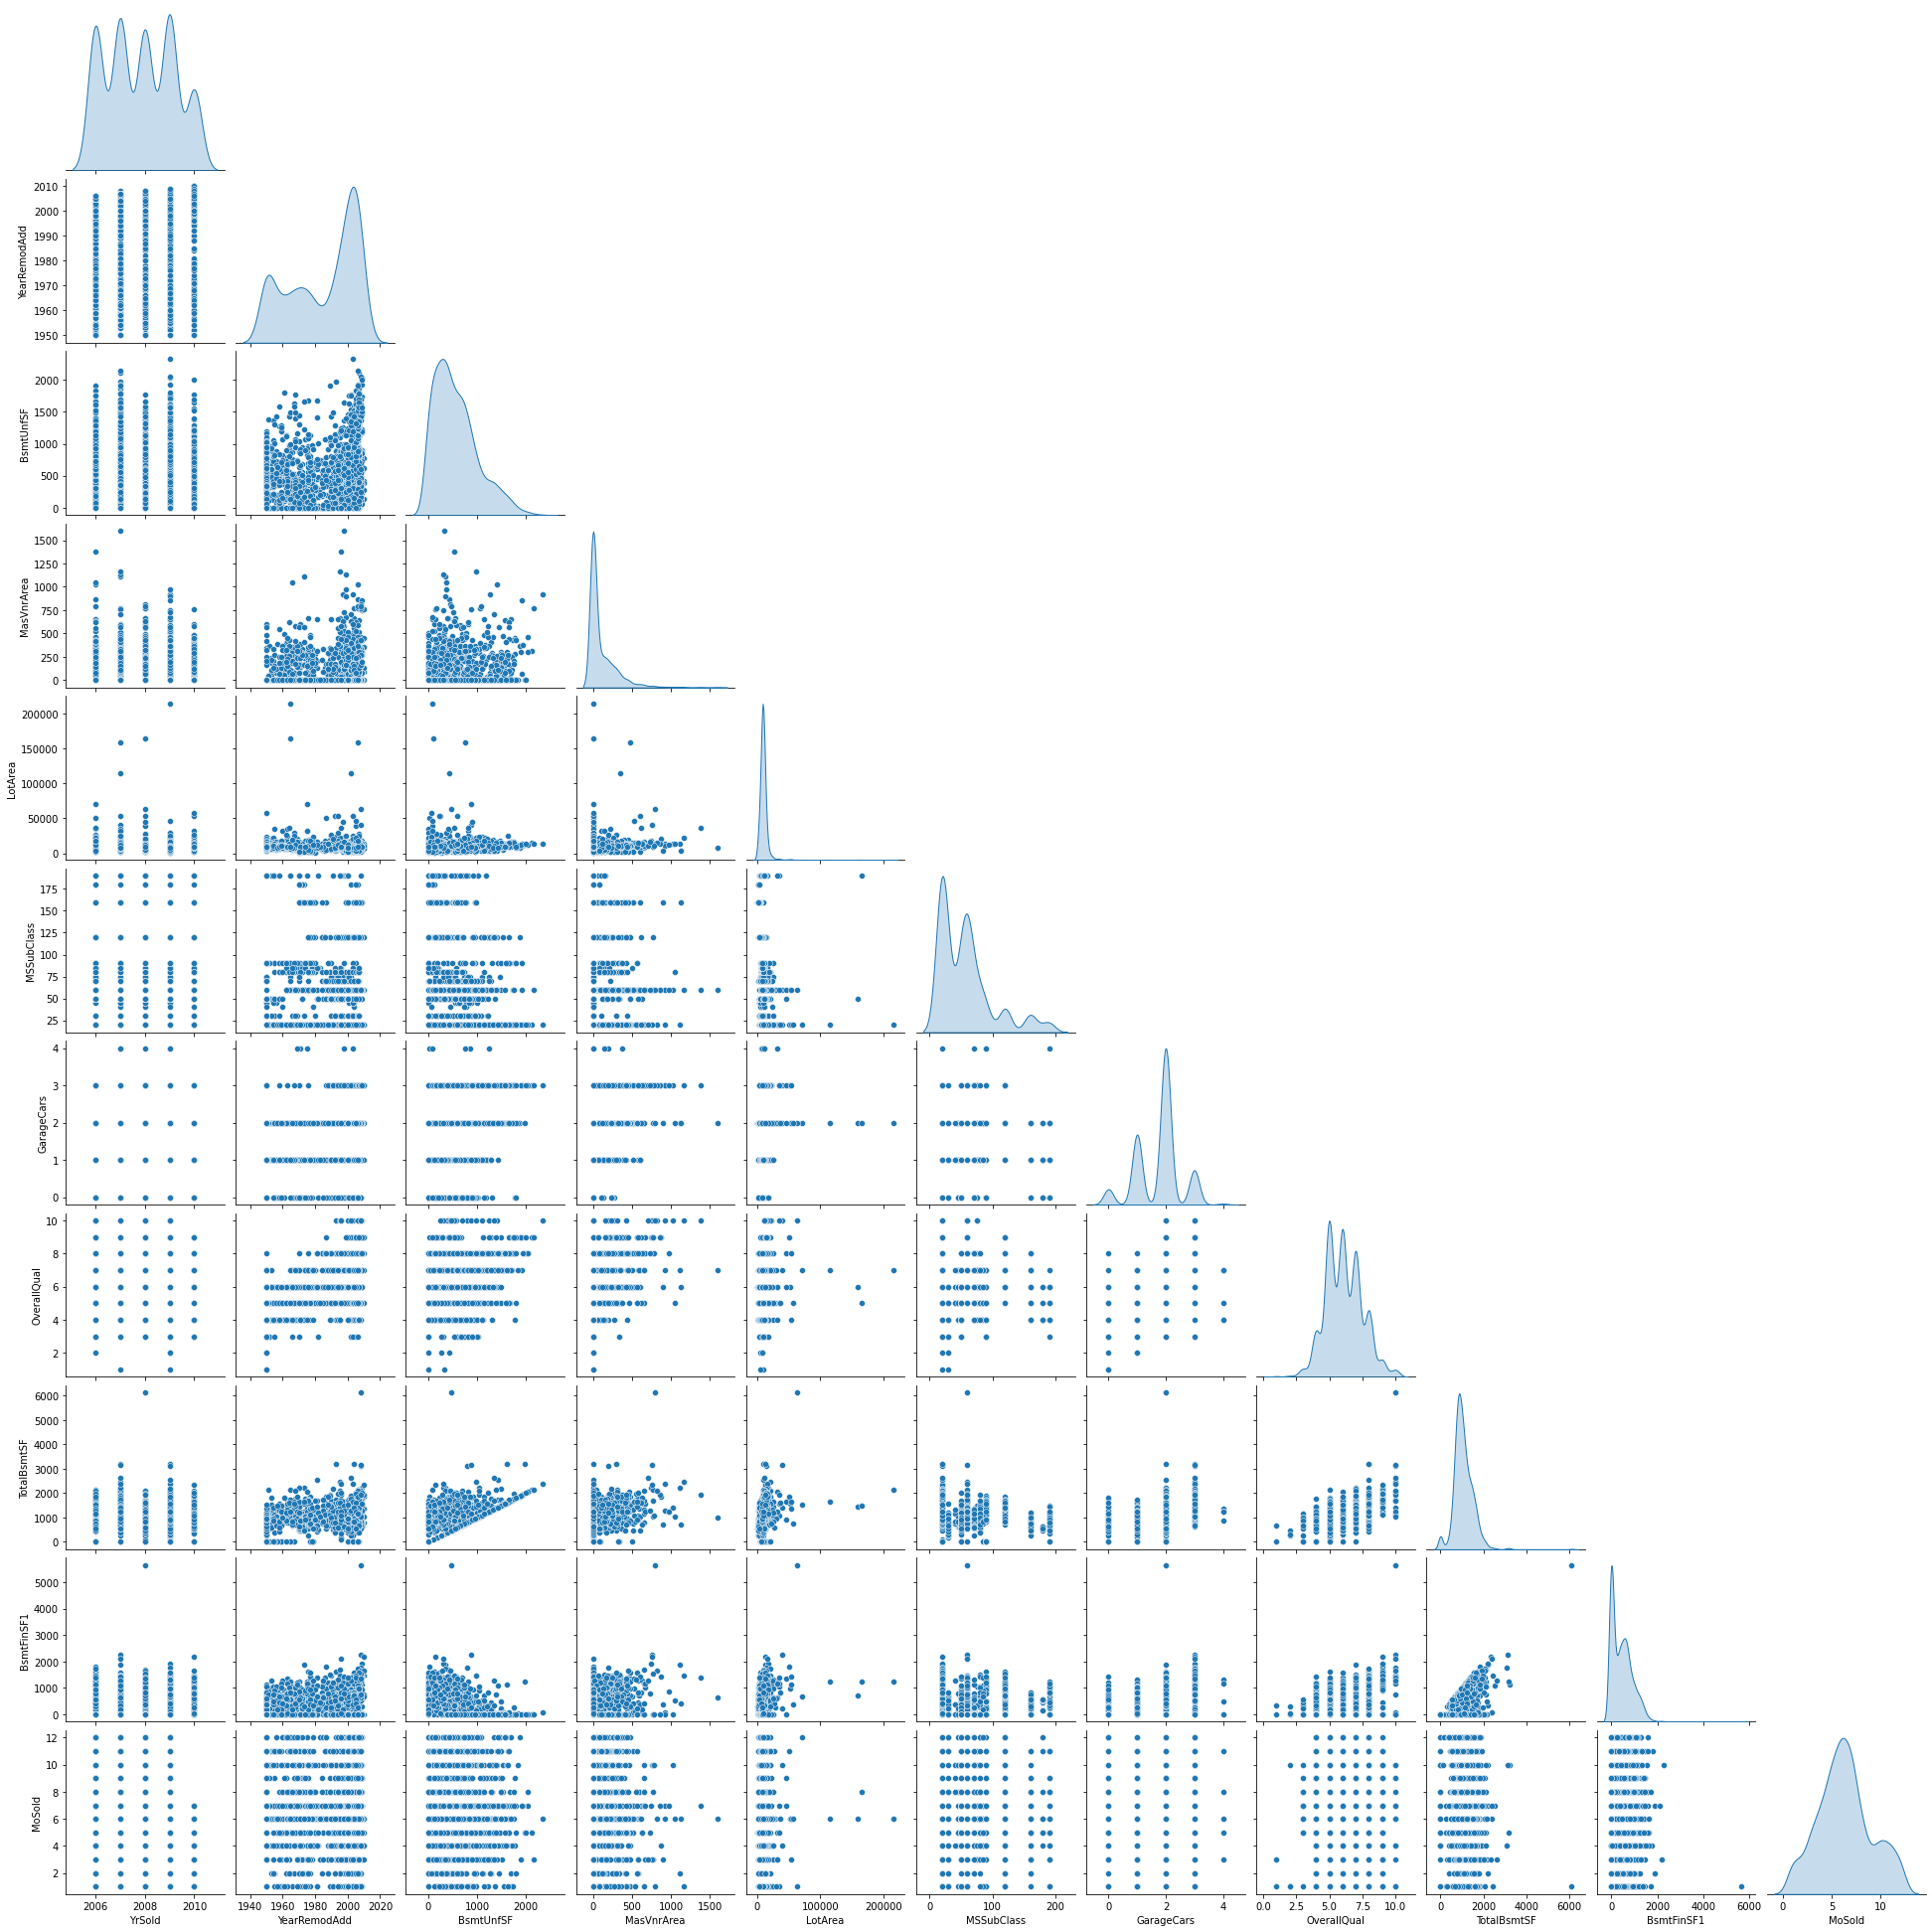

In [39]:
## pair plot
sns.pairplot(X, corner=True, diag_kind="kde");

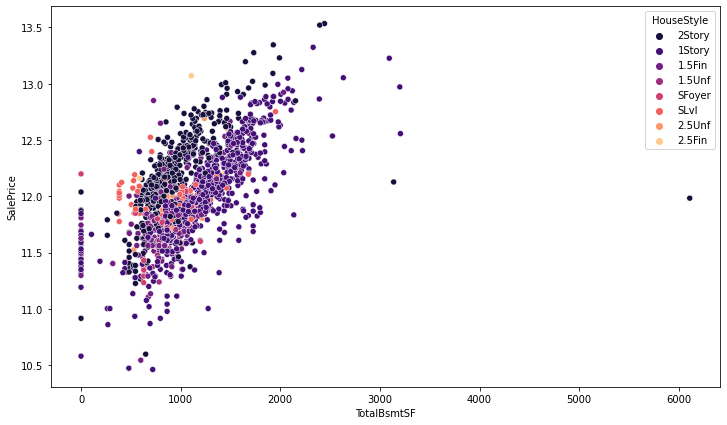

In [40]:
plt.figure(figsize=(12, 7))
sns.scatterplot(x='TotalBsmtSF', y=log_y, data=X, palette='magma', hue='HouseStyle',);

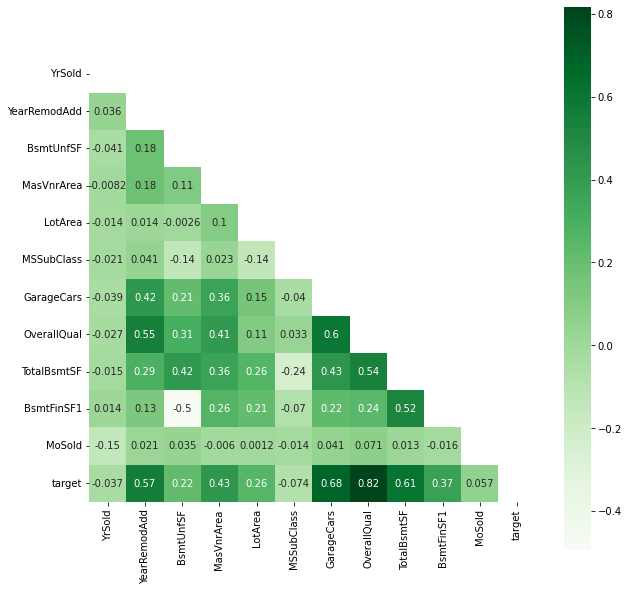

In [41]:
# correlation plot
plt.figure(figsize=(10, 10))
corr = X.assign(target=log_y).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, cmap='Greens', annot=True, square=True, mask=mask, cbar=True, vmin=None, vmax=None);

### Data Preprocessing
Encoding
Machine learning algorithms cannot work with categorical data directly, categorical data must be converted to number.

    1- Label Encoding
    2- One hot encoding
    3- Dummy variable trap
    4- Target encoding
    
**Label encoding** refers to transforming the word labels into numerical form so that the algorithms can understand how to operate on them.

A **One hot encoding** is a representation of categorical variable as binary vectors.It allows the representation of categorical data to be more expresive. This first requires that the categorical values be mapped to integer values, that is label encoding. Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.

The **Dummy variable** trap is a scenario in which the independent variable are multicollinear, a scenario in which two or more variables are highly correlated in simple term one variable can be predicted from the others.

By using pandas get_dummies function we can do all above three step in line of code. We will this fuction to get dummy variable for sex, children,smoker,region features. By setting drop_first =True function will remove dummy variable trap by droping one variable and original variable.The pandas makes our life easy.


The **Target encoding**
For the case of categorical target: features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data.

For the case of continuous target: features are replaced with a blend of the expected value of the target given particular categorical value and the expected value of the target over all the training data.

<br>refer to ``category_encoders``for more details or this kaggle [link](https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark) 

In [42]:
X_encode = pd.get_dummies(data=X, prefix='OHE', prefix_sep='_',
                          columns=categorical_features,
                          drop_first=True,
                          dtype='int8',
                         )
X_encode

,YrSold,YearRemodAdd,BsmtUnfSF,MasVnrArea,LotArea,MSSubClass,GarageCars,OverallQual,TotalBsmtSF,BsmtFinSF1,MoSold,OHE_Fa,OHE_Gd,OHE_Po,OHE_TA,OHE_Pave,OHE_GasA,OHE_GasW,OHE_Grav,OHE_OthW,OHE_Wall,OHE_BrkFace,OHE_None,OHE_Stone,OHE_CBlock,OHE_PConc,OHE_Slab,OHE_Stone,OHE_Wood,OHE_Fa,OHE_Gd,OHE_TA,OHE_Feedr,OHE_Norm,OHE_PosA,OHE_PosN,OHE_RRAe,OHE_RRAn,OHE_RRNn,OHE_Attchd,OHE_Basment,OHE_BuiltIn,OHE_CarPort,OHE_Detchd,OHE_1.5Unf,OHE_1Story,OHE_2.5Fin,OHE_2.5Unf,OHE_2Story,OHE_SFoyer,OHE_SLvl,OHE_Othr,OHE_Shed,OHE_TenC
0,2008.0,2003.0,150.0,196.0,8450.0,60.0,2.0,7.0,856.0,706.0,2.0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2007.0,1976.0,284.0,0.0,9600.0,20.0,2.0,6.0,1262.0,978.0,5.0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2008.0,2002.0,434.0,162.0,11250.0,60.0,2.0,7.0,920.0,486.0,9.0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,2006.0,1970.0,540.0,0.0,9550.0,70.0,3.0,7.0,756.0,216.0,2.0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,2008.0,2000.0,490.0,350.0,14260.0,60.0,3.0,8.0,1145.0,655.0,12.0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2007.0,2000.0,953.0,0.0,7917.0,60.0,2.0,6.0,953.0,0.0,8.0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1456,2010.0,1988.0,589.0,119.0,13175.0,20.0,2.0,6.0,1542.0,790.0,2.0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1457,2010.0,2006.0,877.0,0.0,9042.0,70.0,1.0,7.0,1152.0,275.0,5.0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1458,2010.0,1996.0,0.0,0.0,9717.0,20.0,1.0,5.0,1078.0,49.0,4.0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [45]:
# Lets verify the dummy variable process
print(f"Columns in original data frame:\n {X.columns}\n")
print(f"\nColumns in data frame after encoding dummy variable:\n {X_encode.columns}\n")
print(f"\nNumber of rows and columns in the dataset:", X_encode.shape)

Columns in original data frame:
 Index(['YrSold', 'HeatingQC', 'Street', 'YearRemodAdd', 'Heating',
       'MasVnrType', 'BsmtUnfSF', 'Foundation', 'MasVnrArea', 'LotArea',
       'MSSubClass', 'ExterQual', 'Condition2', 'GarageCars', 'GarageType',
       'OverallQual', 'TotalBsmtSF', 'BsmtFinSF1', 'HouseStyle', 'MiscFeature',
       'MoSold'],
      dtype='object')


Columns in data frame after encoding dummy variable:
 Index(['YrSold', 'YearRemodAdd', 'BsmtUnfSF', 'MasVnrArea', 'LotArea',
       'MSSubClass', 'GarageCars', 'OverallQual', 'TotalBsmtSF', 'BsmtFinSF1',
       'MoSold', 'OHE_Fa', 'OHE_Gd', 'OHE_Po', 'OHE_TA', 'OHE_Pave',
       'OHE_GasA', 'OHE_GasW', 'OHE_Grav', 'OHE_OthW', 'OHE_Wall',
       'OHE_BrkFace', 'OHE_None', 'OHE_Stone', 'OHE_CBlock', 'OHE_PConc',
       'OHE_Slab', 'OHE_Stone', 'OHE_Wood', 'OHE_Fa', 'OHE_Gd', 'OHE_TA',
       'OHE_Feedr', 'OHE_Norm', 'OHE_PosA', 'OHE_PosN', 'OHE_RRAe', 'OHE_RRAn',
       'OHE_RRNn', 'OHE_Attchd', 'OHE_Basment', 'OHE_BuiltIn'

In [46]:
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
                                      ("scaler", StandardScaler())]
                              )

categorical_transformer = make_pipeline(*[SimpleImputer(strategy="constant", fill_value="missing"),
                                          OneHotEncoder(handle_unknown="ignore")]
                                       )


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Append regressor to preprocessing pipeline.
# Now we have a full prediction pipeline.
reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)
reg

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose='deprecated')),
                                                                  ('scaler',
                                                                   StandardScaler(copy=Tru...
                                                                                 sparse=True))],
                                                           verbose=False),
                                                  Index(['HeatingQC', 'Street', 'Heating', 'MasVnrType', 'Foundation',
       'ExterQual', 'Condition2', 'GarageType', 'HouseStyle', 'MiscFeature'],
      dtype='object'))],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize='deprecated', positive=False))],
         verbose=False)

## Modeling - Linear Regression

### Train/test split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, log_y, test_size=0.25, random_state=23)

### Linear regression

In [48]:
reg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose='deprecated')),
                                                                  ('scaler',
                                                                   StandardScaler(copy=Tru...
                                                                                 sparse=True))],
                                                           verbose=False),
                                                  Index(['HeatingQC', 'Street', 'Heating', 'MasVnrType', 'Foundation',
       'ExterQual', 'Condition2', 'GarageType', 'HouseStyle', 'MiscFeature'],
      dtype='object'))],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize='deprecated', positive=False))],
         verbose=False)

### Model evaluation

In [49]:
# sklearn regression module
y_test_pred = reg.predict(X_test)
y_train_pred = reg.predict(X_train)

In [50]:
def get_performances(real_value, estimated_value, metrics):
    perfs = []
    for metric_func in metrics:
        perfs.append((metric_func.__name__, metric_func(real_value, estimated_value)))
    return pd.DataFrame(perfs, columns=["metric", "value"])


def get_all_performances(value_train, values_test, metrics):
    test_perfs = []
    train_perfs = []
    metric_names = []
    for metric_func in metrics:
        metric_name = metric_func.__name__
        metric_names.append(metric_name)
        train_perfs.append(metric_func(*value_train))
        test_perfs.append(metric_func(*values_test))
    perfs = {"metric": metric_names, "train": train_perfs, "test": test_perfs,}
    return pd.DataFrame(perfs)

In [51]:
METRICS = [r2_score,
           mean_squared_error,
           mean_absolute_percentage_error,
           max_error,
          ]
# get performance on single set
get_performances(real_value=y_test, estimated_value=y_test_pred, metrics=METRICS)

,metric,value
0,r2_score,-1.964925e+20
1,mean_squared_error,3.048581e+19
2,mean_absolute_percentage_error,4.257291e+07
3,max_error,6.090243e+10


In [52]:
# get performances in train & test
get_all_performances(value_train=(y_train, y_train_pred),
                     values_test=(y_test, y_test_pred),
                     metrics=METRICS
                    )

,metric,train,test
0,r2_score,0.805444,-1.964925e+20
1,mean_squared_error,0.031291,3.048581e+19
2,mean_absolute_percentage_error,0.010470,4.257291e+07
3,max_error,2.020001,6.090243e+10


### Model Validation
In order to validated model we need to check few assumption of linear regression model. The common assumption for Linear Regression model are following

- Linear Relationship: In linear regression the relationship between the dependent and independent variable to be linear. This - can be checked by scatter ploting Actual value Vs Predicted value
- The residual error plot should be normally distributed.
- The mean of residual error should be 0 or close to 0 as much as possible
- The linear regression require all variables to be multivariate normal. This assumption can best checked with Q-Q plot.
- Linear regession assumes that there is little or no Multicollinearity in the data. Multicollinearity occurs when the independent variables are too highly correlated with each other. The variance inflation factor VIF* identifies correlation between independent variables and strength of that correlation. [Math Processing Error], If VIF >1 & VIF <5 moderate correlation, VIF < 5 critical level of multicollinearity.
- Homoscedasticity: The data are homoscedastic meaning the residuals are equal across the regression line. We can look at residual Vs fitted value scatter plot. If heteroscedastic plot would exhibit a funnel shape pattern.

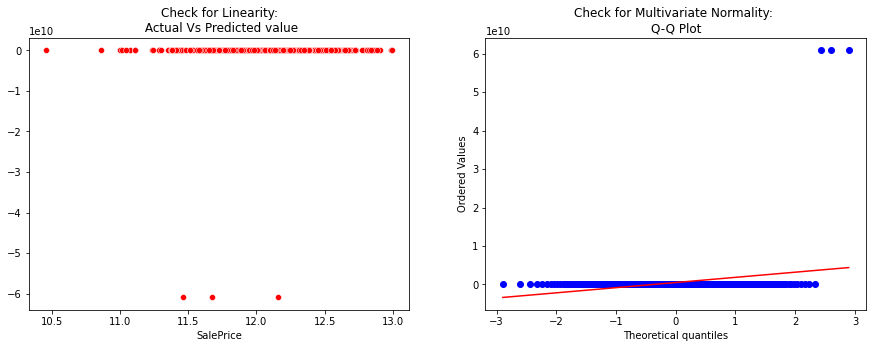

In [53]:
# Check for Linearity
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax = axes[0]
g = sns.scatterplot(x=y_test, y=y_test_pred, ax=ax, color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = axes[1]
residus = y_test - y_test_pred
_, (_, _, r)= sp.stats.probplot(residus, fit=True,plot=ax)
ax.set_title('Check for Multivariate Normality: \nQ-Q Plot');

In [54]:
# Check for Multicollinearity
# Variance Inflation Factor (VIF)
R_square_test = mean_squared_error(y_test, y_test_pred, squared=True)
VIF = 1/(1- R_square_test)
VIF

-3.280215146406255e-20

### Tuning hyperpameters

In [55]:
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "regressor__fit_intercept": [True, False],
}

grid_search = GridSearchCV(reg, param_grid, cv=10, scoring="r2", return_train_score=True) # r2
# you can see the list of key for scoring: sorted(sklearn.metrics.SCORERS.keys())
grid_search

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                                                                                        fill_value=None,
                                                                                                        missing_values=nan,
                                                                                                        strategy='median',
                                                                                                        verbose='de...
                                                          verbose_feature_names_out=True)),
                                       ('regressor',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize='deprecated',
                                                         positive=False))],
                                verbose=False),
             n_jobs=None,
             param_grid={'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median'],
                         'regressor__fit_intercept': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

In [56]:
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best params: {best_params}")

Best params: {'preprocessor__num__imputer__strategy': 'median', 'regressor__fit_intercept': True}


In [57]:
grid_cv_results = grid_search.cv_results_
for group in ["train", "test"]:
    mean_score = round(100 * grid_cv_results[f'mean_{group}_score'].mean(), 2)
    mean_std_score = round(grid_cv_results[f'std_{group}_score'].mean(), 2)
    print(f"{group}====================\nMean score (std): {mean_score} ({mean_std_score})\n")

train====================
Mean score (std): 81.87 (0.03)

test====================
Mean score (std): -2.1379335277989926e+24 (5.000810976940822e+22)



In [58]:
print(f"Internal CV score: {grid_search.best_score_: .3f}")

Internal CV score: -568332284121403228160.000


In [59]:
cv_results = pd.DataFrame(grid_cv_results)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[["mean_train_score", "std_train_score",
            "mean_test_score", "std_test_score",
            "mean_fit_time", "std_fit_time",
            "mean_score_time", "std_score_time"
           ]]

,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
2,0.819264,0.023841,-5.683323e+20,1.555756e+21,0.033897,0.005228,0.010464,0.001508
1,0.828212,0.010250,-1.931847e+22,3.183767e+22,0.030583,0.003873,0.009766,0.001476
0,0.816676,0.032213,-2.113722e+22,6.339816e+22,0.031038,0.004960,0.009614,0.000812
3,0.810588,0.040311,-4.449331e+22,1.032409e+23,0.033046,0.005927,0.011044,0.002493


In [60]:
#cross validation only
cv_results = cross_validate(reg,
                            X_train, y_train,
                            cv=5,
                            scoring=('r2', 'neg_mean_squared_error'),
                            return_train_score=True)
pd.DataFrame(cv_results)

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error
0,0.029392,0.028508,-3.577258e+20,0.825403,-5.651696e+19,-0.027989
1,0.045334,0.009810,-3.307876e+18,0.825155,-5.447267e+17,-0.027948
2,0.026723,0.010567,-2.539865e+18,0.797562,-4.304951e+17,-0.031948
3,0.029740,0.011133,-6.273949e+18,0.865270,-8.595805e+17,-0.022471
4,0.037631,0.010977,-5.885421e+16,0.824455,-9.900188e+15,-0.027908


### Feature importances

In [61]:
reg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose='deprecated')),
                                                                  ('scaler',
                                                                   StandardScaler(copy=Tru...
                                                                                 sparse=True))],
                                                           verbose=False),
                                                  Index(['HeatingQC', 'Street', 'Heating', 'MasVnrType', 'Foundation',
       'ExterQual', 'Condition2', 'GarageType', 'HouseStyle', 'MiscFeature'],
      dtype='object'))],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('regressor',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize='deprecated', positive=False))],
         verbose=False)

In [62]:
print(f"Model score - training data: {reg.score(X_train, y_train)}")
print(f"Model score - test data: {reg.score(X_test, y_test)}")

Model score - training data: 0.8054436329239076
Model score - test data: -1.9649249724330502e+20


In [63]:
reg_estimator = reg["regressor"]

In [66]:
def get_input_features(model_pipeline, cat_step_name):
    """ Get model feature names used in training
    
    """

    all_feature_names = []

    for step_name, pipe_trans, feat_names in reg["preprocessor"].transformers_:
        if step_name == cat_step_name:
            all_feature_names.extend(pipe_trans
                                 .named_steps["onehotencoder"]
                                 .get_feature_names_out(input_features=categorical_features)
                                )
        else:
            all_feature_names.extend(feat_names)
    return all_feature_names

In [68]:
model_features = get_input_features(model_pipeline=reg, cat_step_name="cat")
model_features

['YrSold',
 'YearRemodAdd',
 'BsmtUnfSF',
 'MasVnrArea',
 'LotArea',
 'MSSubClass',
 'GarageCars',
 'OverallQual',
 'TotalBsmtSF',
 'BsmtFinSF1',
 'MoSold',
 'HeatingQC_Ex',
 'HeatingQC_Fa',
 'HeatingQC_Gd',
 'HeatingQC_Po',
 'HeatingQC_TA',
 'Street_Grvl',
 'Street_Pave',
 'Heating_Floor',
 'Heating_GasA',
 'Heating_GasW',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'MasVnrType_BrkCmn',
 'MasVnrType_BrkFace',
 'MasVnrType_None',
 'MasVnrType_Stone',
 'MasVnrType_None',
 'Foundation_BrkTil',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Foundation_Slab',
 'Foundation_Stone',
 'Foundation_Wood',
 'ExterQual_Ex',
 'ExterQual_Fa',
 'ExterQual_Gd',
 'ExterQual_TA',
 'Condition2_Feedr',
 'Condition2_Norm',
 'Condition2_PosA',
 'Condition2_PosN',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'GarageType_2Types',
 'GarageType_Attchd',
 'GarageType_Basment',
 'GarageType_BuiltIn',
 'GarageType_CarPort',
 'GarageType_Detchd',
 'GarageType_None',
 'HouseStyle_1.5Fin',
 'HouseStyle_1.5Unf',
 'H

In [69]:
df_feature_importance = pd.DataFrame(reg_estimator.coef_, columns=["coef"], index=model_features)
print(f"Shape: {df_feature_importance.shape}")
df_feature_importance.head()

Shape: (65, 1)


,coef
YrSold,-0.006613
YearRemodAdd,0.036028
BsmtUnfSF,-0.037167
MasVnrArea,0.030333
LotArea,0.038918


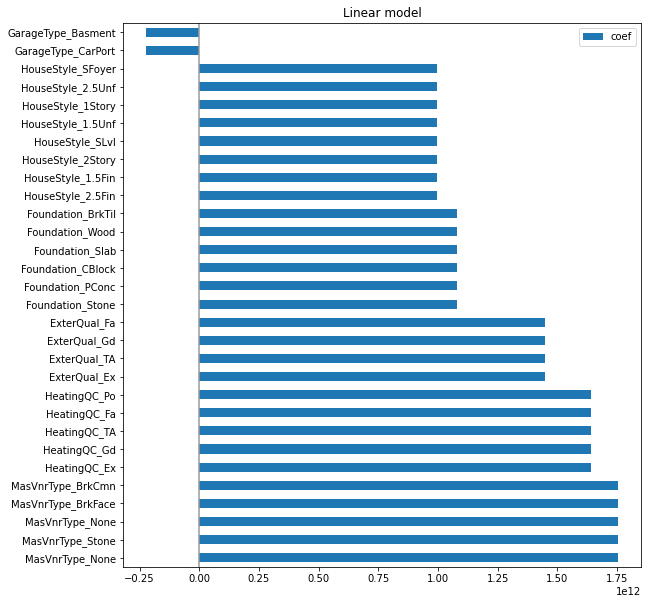

In [70]:
# top30 most important features
(df_feature_importance
 .sort_values("coef", key=lambda v: abs(v), ascending=False)
 .head(30)
 .plot(kind="barh", figsize=(12, 10))
)
plt.title("Linear model")
plt.axvline(x=0, color='.6')
plt.subplots_adjust(left=.3);

## Ridge

### Define pipeline

In [71]:
def define_pipeline(estimator,
                    parameters,
                    numeric_transformer,
                    categorical_transformer
                   ):
    """ Construct a Pipeline from the given transfomers & estimators
    """
    if not parameters:
        parameters = dict()
    numeric_transformer = make_pipeline(*numeric_transformer)
    categorical_transformer = make_pipeline(*categorical_transformer)


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", make_pipeline(*numeric_transformer), make_column_selector(dtype_include="number")),
            ("cat", make_pipeline(*categorical_transformer), make_column_selector(dtype_include=["object"])),
        ]
    )

    # Append estimator to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    return Pipeline(steps=[("preprocessor", preprocessor), ("regressor", estimator(**parameters))])
    

### Modeling

In [72]:
NUMERIC_TRANSFORMER = [SimpleImputer(strategy="median"),
                       StandardScaler()]
CATEGORY_TRANSFORMER = [SimpleImputer(strategy="constant", fill_value="missing"),
                        OneHotEncoder(handle_unknown="ignore")]
reg_ridge = define_pipeline(estimator=RidgeCV,
                            parameters=None,
                            numeric_transformer=NUMERIC_TRANSFORMER,
                            categorical_transformer=CATEGORY_TRANSFORMER
                           )
reg_ridge

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                                 verbose='deprecated')),
                                                                  ('standardscaler',
                                                                   StandardS...
                                                                                 min_frequency=None,
                                                                                 sparse=True))],
                                                           verbose=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f880fe0bd60>)],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('regressor',
                 RidgeCV(alpha_per_target=False, alphas=(0.1, 1.0, 10.0),
                         cv=None, fit_intercept=True, gcv_mode=None,
                         normalize='deprecated', scoring=None,
                         store_cv_values=False))],
         verbose=False)

### Cross validation

In [73]:
# cross validation only
cv_results = cross_validate(reg_ridge,
                            X_train, y_train,
                            cv=5,
                            scoring=("r2", "neg_mean_squared_error",
                                     "neg_mean_absolute_percentage_error", "neg_mean_absolute_error"),
                            return_train_score=True)
cv_result_ridge = pd.DataFrame(cv_results)
cv_result_ridge

,fit_time,score_time,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_mean_absolute_error,train_neg_mean_absolute_error
0,0.087648,0.015794,0.845061,0.810420,-0.024479,-0.030391,-0.009767,-0.009999,-0.118403,-0.119483
1,0.029775,0.008951,0.817238,0.818687,-0.030096,-0.028982,-0.010853,-0.009761,-0.130676,-0.116772
2,0.033255,0.009375,0.803631,0.818608,-0.033284,-0.028626,-0.010908,-0.009620,-0.128418,-0.115697
3,0.030869,0.010134,0.595885,0.852786,-0.055367,-0.024553,-0.010369,-0.009221,-0.124680,-0.110179
4,0.029464,0.008686,0.811840,0.818693,-0.031651,-0.028825,-0.009631,-0.009849,-0.114777,-0.118006


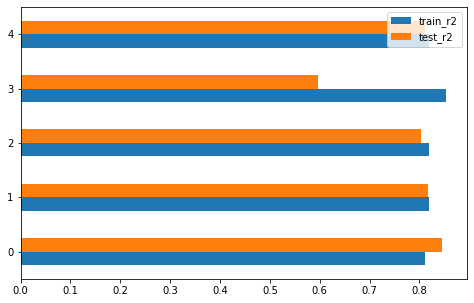

In [74]:
cv_result_ridge[["train_r2", "test_r2"]].plot(kind="barh", figsize=(8, 5));

In [75]:
reg_ridge.fit(X_train, y_train)
print(f"Model score - training data: {reg_ridge.score(X_train, y_train)}")
print(f"Model score - test data: {reg_ridge.score(X_test, y_test)}")

Model score - training data: 0.8209813984891026
Model score - test data: 0.8398500683266751


In [76]:
ridge_model_features = get_input_features(model_pipeline=reg_ridge, cat_step_name="cat")

df_feature_importance_ridge = pd.DataFrame(reg_ridge.named_steps["regressor"].coef_, columns=["coef"], index=model_features)
print(f"Shape: {df_feature_importance_ridge.shape}")
df_feature_importance_ridge.head()

Shape: (65, 1)


,coef
YrSold,-0.006000
YearRemodAdd,0.041227
BsmtUnfSF,-0.032424
MasVnrArea,0.019272
LotArea,0.036198


### Feature importances

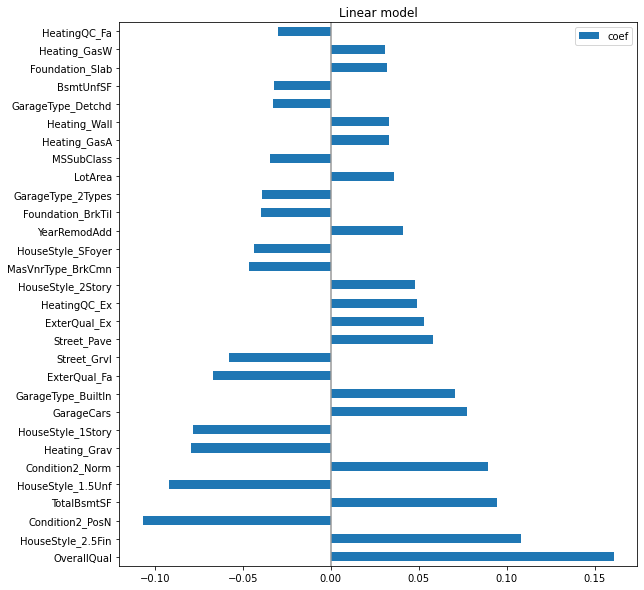

In [77]:
# top30 most important features
(df_feature_importance_ridge
 .sort_values("coef", key=lambda v: abs(v), ascending=False)
 .head(30)
 .plot(kind="barh", figsize=(12, 10))
)
plt.title("Linear model")
plt.axvline(x=0, color='.6')
plt.subplots_adjust(left=.3);

## Todo
 - Lasso
 - Elasticnet
 - ...